# Forest Cover Type Prediction
### 3. Further Experiments to Improve Model Performance (1)
![forest-cover-type-coverimage](https://kaggle2.blob.core.windows.net/competitions/kaggle/3936/logos/front_page.png)
<center>https://www.kaggle.com/c/forest-cover-type-prediction</center>


In [1]:
import random
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from mlxtend.classifier import EnsembleVoteClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
X_scaled_train = pd.read_csv('data/X_scaled_train.csv')
X_scaled_test = pd.read_csv('data/X_scaled_test.csv')
y_train = pd.read_csv('data/train.csv', usecols=['Cover_Type']).values.ravel()
etc_gini_rfecv = pd.read_csv('data/rfecv_etc_gini.csv').values.ravel().tolist()
X_scaled_train_best = X_scaled_train[etc_gini_rfecv]
etc_best_params = {'class_weight': 'balanced',
                     'criterion': 'gini',
                     'max_depth': 50,
                     'max_features': 0.3,
                     'max_leaf_nodes': None,
                     'min_impurity_decrease': 0,
                     'min_samples_leaf': 1,
                     'min_samples_split': 2,
                     'n_estimators': 200}

etc_best = ExtraTreesClassifier(**etc_best_params, random_state=0)

## Experiment 1. Class Weights

* Analyze which labels our best model do not predict well
* Add more weights to the labels found as week points

In [29]:
def cv_kfold(dfX, dfy, model, num_splits, print_=0):
    
    scores = cross_val_score(model, dfX, dfy, scoring='accuracy',cv=num_splits)
    
    if print_:
        print(scores)
        print(np.mean(scores), np.std(scores))
    
    return (np.mean(scores))

In [30]:
def draw_confmat(confmat):
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.show()

In [31]:
wrongs_tn = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0}
wrongs_fp = {'1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0}
confmat_summed = []
wrongs_indices = {}

for i in range(10):
    X_train_, X_test_, y_train_, y_test_ = train_test_split(
                            X_scaled_train_best, y_train, test_size=0.1, random_state=i)
    
    etc_best_fit = etc_best.fit(X_train_, y_train_)
    y_hat = etc_best_fit.predict(X_test_)
    
    compare = pd.Series(y_test_ == y_hat)

    wrongs_idx = compare[compare==False].index
    wrongs = pd.Series(y_test_)[wrongs_idx].value_counts()
    
    for i in range(1, 8):
        wrongs_tn[str(i)] += wrongs[i]
        
    for widx in wrongs_idx:
        if widx in wrongs_indices:
            wrongs_indices[widx] += 1
        else:
            wrongs_indices[widx] = 1
    
    confmat = confusion_matrix(y_true=y_test_, y_pred=y_hat)
    
    if type(confmat_summed) != list:
        confmat_summed = np.add(confmat, confmat_summed)
    else:
        confmat_summed = confmat
    

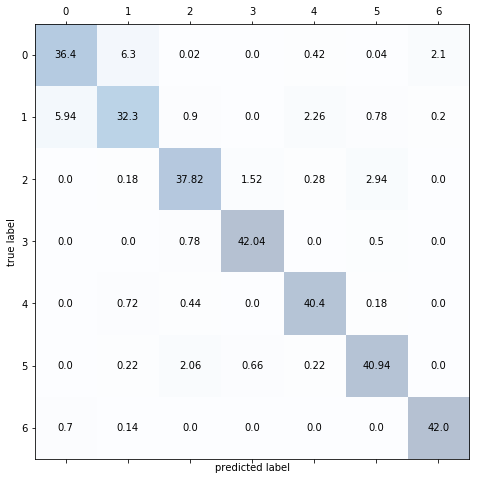

In [32]:
draw_confmat(confmat_summed/50)

In [33]:
# each number is average number from 50 tests
confmat_avg = confmat_summed/50

In [34]:
# average number of true negatives
tn = confmat_avg.sum(axis=1) - confmat_summed.diagonal()/50
tn_reg = tn / np.min(tn)

In [35]:
# average number of false positives
fp = confmat_avg.sum(axis=0) - confmat_summed.diagonal()/50
fp_reg = fp / np.min(fp)

In [36]:
# test weight 1 : calculate weights based on true negatives
# test weight 2 : calculate weights based on false positives

test_weight_1 = {i+1 : tn for i, tn in enumerate(tn_reg)}
test_weight_2 = {i+1 : fp for i, fp in enumerate(fp_reg)}

In [37]:
test_weight_1

{1: 10.571428571428532,
 2: 11.999999999999948,
 3: 5.8571428571428354,
 4: 1.5238095238095191,
 5: 1.5952380952380845,
 6: 3.7619047619047512,
 7: 1.0}

In [38]:
test_weight_2

{1: 3.0458715596330284,
 2: 3.467889908256879,
 3: 1.9266055045871575,
 4: 1.0,
 5: 1.4587155963302754,
 6: 2.0366972477064214,
 7: 1.0550458715596318}

In [39]:
test_weight_3 = {v1[0] : v1[1]*v2[1] for v1, v2  in zip(list(test_weight_1.items()), list(test_weight_2.items()))}
test_weight_3

{1: 32.199213630406177,
 2: 41.614678899082371,
 3: 11.284403669724737,
 4: 1.5238095238095191,
 5: 2.3269986893839949,
 6: 7.6618610747050875,
 7: 1.0550458715596318}

### Most of wrong predictions are found in class label `1`, `2`, `3` and `6`.
* Applying the class weights to our best model and see the score again
* `Blue` and `green` dots in the pca/lda graph below.

In [14]:
def draw_pca_lda_2d(X_, y_):
    pca = PCA(n_components=2)
    X_selected_2d = pca.fit_transform(X_)
    plt.scatter(X_selected_2d[:,0], X_selected_2d[:,1], c=y_train, s=50, cmap=plt.cm.Paired)
    plt.colorbar()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('First two PCs using digits data')
    plt.show()

    lda = LDA(n_components=2)
    X_selected_2d = lda.fit_transform(X_, y_)

    plt.scatter(X_selected_2d[:,0], X_selected_2d[:,1], c=y_train, s=50, cmap=plt.cm.Paired)
    plt.colorbar()
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('First two PCs using digits data')
    plt.show()

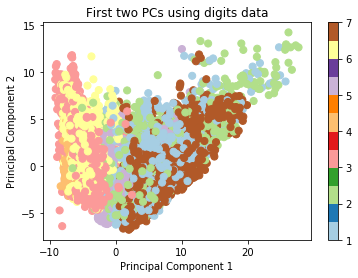

/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/usr/local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


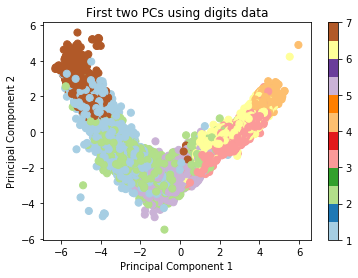

In [15]:
draw_pca_lda_2d(X_scaled_train_best, y_train)

In [18]:
etc_best.set_params(class_weight = test_weight_3)

ExtraTreesClassifier(bootstrap=False,
           class_weight={1: 32.199213630406177, 2: 41.614678899082371, 3: 11.284403669724737, 4: 1.5238095238095191, 5: 2.3269986893839949, 6: 7.6618610747050875, 7: 1.0550458715596318},
           criterion='gini', max_depth=50, max_features=0.3,
           max_leaf_nodes=None, min_impurity_decrease=0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [22]:
cv_kfold(X_scaled_train_best, y_train, etc_best, 5)

0.81990740740740742

In [23]:
# reset params and cross validate again
etc_best.set_params(class_weight = 'balanced')
cv_kfold(X_scaled_train_best, y_train, etc_best, 5)

0.81990740740740742

### Not improved.
* Try again with bigger weights.

In [43]:
test_weight_3_sqrd = {k:v**2 for k,v in test_weight_3.items()}
test_weight_3_sqrd

{1: 1036.7893584165349,
 2: 1731.7814998737315,
 3: 127.33776618129711,
 4: 2.3219954648525931,
 5: 5.4149229003948296,
 6: 58.704115128081,
 7: 1.1131217910950231}

In [25]:
# set params and cross validate again - score dropped more.
etc_best.set_params(class_weight = test_weight_3_sqrd)
cv_kfold(X_scaled_train_best, y_train, etc_best, 5)

0.812037037037037

### Following Assumtion.

* Each data sample is not properly divided due to the duplicated / collinear columns
* **`What if we exclude the correlated columns(numerical)?`**

### In the tree-based model, when using the columns representing same information in multiple times, it means that the model is to `focus more` on the information.

### We will group columns like `[original_column, original_column_log, original_column_sqrd, original_column_cube]` and randomly choose one to put into the model.

In [3]:
import re

In [4]:
columns_excluding_dups = X_scaled_train_best.columns.tolist()
cols_ex_cups_joined = ' '.join(columns_excluding_dups)

In [5]:
# original columns with log version
original_cols_with_log = pd.Series(re.findall(r'[A-Za-z0-9_]+_log', cols_ex_cups_joined))\
                                    .apply(lambda x: x[:-4]).tolist()

In [6]:
# original columns with sqrd version
original_cols_with_sqrd = pd.Series(re.findall(r'[A-Za-z0-9_]+_sqrd', cols_ex_cups_joined))\
                                    .apply(lambda x: x[:-5]).tolist()

In [7]:
# original columns with cube version
original_cols_with_cube = pd.Series(re.findall(r'[A-Za-z0-9_]+_cube', cols_ex_cups_joined))\
                                    .apply(lambda x: x[:-5]).tolist()

In [8]:
original_cols_with_sqrd_or_cube_or_log = list(set(original_cols_with_sqrd\
                                                   + original_cols_with_cube\
                                                   + original_cols_with_log))

In [9]:
def find_dup_cols(orgcol):
    cols_to_return = [orgcol]
    
    if orgcol + '_sqrd' in columns_excluding_dups:
        cols_to_return.append(orgcol + '_sqrd')
    if orgcol + '_cube' in columns_excluding_dups:
        cols_to_return.append(orgcol + '_cube')
    if orgcol + '_log' in columns_excluding_dups:
        cols_to_return.append(orgcol + '_log')
            
    return cols_to_return

In [10]:
dupcols_grouped = pd.Series(original_cols_with_sqrd_or_cube_or_log).apply(find_dup_cols).tolist()
dupcols_grouped

[['Hillshade_Mult_0912',
  'Hillshade_Mult_0912_sqrd',
  'Hillshade_Mult_0912_cube'],
 ['Horizontal_Distance_To_Hydrology',
  'Horizontal_Distance_To_Hydrology_sqrd',
  'Horizontal_Distance_To_Hydrology_log'],
 ['Horizontal_Distance_Sum_RF',
  'Horizontal_Distance_Sum_RF_sqrd',
  'Horizontal_Distance_Sum_RF_cube'],
 ['Horizontal_Distance_Sum_HRF', 'Horizontal_Distance_Sum_HRF_sqrd'],
 ['Horizontal_Distance_Diff_RF',
  'Horizontal_Distance_Diff_RF_sqrd',
  'Horizontal_Distance_Diff_RF_cube'],
 ['Hillshade_Diff', 'Hillshade_Diff_cube'],
 ['Hillshade_9am', 'Hillshade_9am_sqrd', 'Hillshade_9am_cube'],
 ['Horizontal_Distance_Diff_HF', 'Horizontal_Distance_Diff_HF_sqrd'],
 ['Horizontal_Distance_To_Fire_Points',
  'Horizontal_Distance_To_Fire_Points_sqrd',
  'Horizontal_Distance_To_Fire_Points_cube',
  'Horizontal_Distance_To_Fire_Points_log'],
 ['Vertical_Distance_Diff_EH',
  'Vertical_Distance_Diff_EH_sqrd',
  'Vertical_Distance_Diff_EH_cube'],
 ['Horizontal_Distance_Sum_HR',
  'Horizontal_

In [11]:
import random

columns_nodups = [col for col in X_scaled_train_best.columns.tolist()
                     if col not in [dupcol for group in dupcols_grouped for dupcol in group]]

def select_cols_nodups(seednum):
    random.seed(seednum)
    columns_nodups_ = columns_nodups[:]
    for dupcol in dupcols_grouped:
        dupcol_leng = len(dupcol)
        rand_index = random.randint(0, dupcol_leng-1)
        columns_nodups_.append(dupcol[rand_index])
        
    return columns_nodups_

def cv_kfold(dfX, dfy, model, num_splits, print_=0):
    
    scores = cross_val_score(model, dfX, dfy, scoring='accuracy',cv=num_splits)
    
    if print_:
        print(scores)
        print(np.mean(scores), np.std(scores))
    
    return (np.mean(scores))

def cv_with_random_nodups(seednum):
    selected_cols = select_cols_nodups(seednum)
    return selected_cols, cv_kfold(X_scaled_train[selected_cols], y_train, etc_best, 5)

In [12]:
# Test for 10 times
ran_test_cols, ran_test_scores = [], []

for i in range(10):

    col, score = cv_with_random_nodups(i)
    ran_test_cols.append(col)
    ran_test_scores.append(score)
    

In [13]:
ran_test_scores

[0.81111111111111112,
 0.81197089947089951,
 0.812037037037037,
 0.81269841269841281,
 0.81078042328042321,
 0.81104497354497362,
 0.80932539682539684,
 0.8127645502645503,
 0.81097883597883613,
 0.81111111111111112]

### Not improved.

In [14]:
etc_best

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='gini', max_depth=50, max_features=0.3,
           max_leaf_nodes=None, min_impurity_decrease=0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

## Experiment 2. Supplement data
* Duplicate samples with target label `1`, `2` in the train data to increase the class importance
  * This approach is based on the same logic with setting `class_weight` - since class weights do not seem to work, we will try this way.

In [15]:
y_train_srs = pd.Series(y_train)

In [16]:
y_train_srs_c12 = y_train_srs[(y_train_srs==1) | (y_train_srs == 2)]

In [17]:
X_scaled_train_best_c12 = X_scaled_train_best.iloc[y_train_srs_c12.index]

In [18]:
X_scaled_train_concat = pd.concat([X_scaled_train_best, X_scaled_train_best_c12], axis=0).reset_index(drop=True)
y_train_concat = pd.concat([y_train_srs, y_train_srs_c12], axis=0).reset_index(drop=True)

In [58]:
etc_best

ExtraTreesClassifier(bootstrap=False,
           class_weight={1: 1036.7893584165349, 2: 1731.7814998737315, 3: 127.33776618129711, 4: 2.3219954648525931, 5: 5.4149229003948296, 6: 58.704115128081, 7: 1.1131217910950231},
           criterion='gini', max_depth=50, max_features=0.3,
           max_leaf_nodes=None, min_impurity_decrease=0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [60]:
# class_weight = test_weight_3_sqrd
cv_kfold(X_scaled_train_concat,
        y_train_concat,
        etc_best, 5, print_ = 1)

[ 0.89660494  0.92386831  0.91306584  0.93441358  0.97170782]
0.927932098765 0.0252080707769


0.92793209876543215

In [63]:
# class_weight = test_weight_3
etc_best.set_params(class_weight=test_weight_3)
cv_kfold(X_scaled_train_concat,
        y_train_concat,
        etc_best, 5, print_ = 1)

[ 0.89326132  0.92926955  0.91692387  0.93389918  0.97016461]
0.928703703704 0.0250649041485


0.92870370370370381

In [64]:
# class_weight = test_weight_2
etc_best.set_params(class_weight=test_weight_2)
cv_kfold(X_scaled_train_concat,
        y_train_concat,
        etc_best, 5, print_ = 1)

[ 0.89866255  0.92978395  0.91949588  0.93081276  0.9688786 ]
0.929526748971 0.0228188743798


0.92952674897119336

In [65]:
# class_weight = test_weight_1
etc_best.set_params(class_weight=test_weight_1)
cv_kfold(X_scaled_train_concat,
        y_train_concat,
        etc_best, 5, print_ = 1)

[ 0.89583333  0.92669753  0.91718107  0.93467078  0.9683642 ]
0.928549382716 0.0237726682729


0.92854938271604937

In [61]:
# class_weight = balanced
etc_best.set_params(class_weight='balanced')
cv_kfold(X_scaled_train_concat,
        y_train_concat,
        etc_best, 5, print_ = 1)

[ 0.90226337  0.92772634  0.91615226  0.93055556  0.9691358 ]
0.929166666667 0.0223369523464


0.92916666666666681

### Best 2 test weight = `test_weight_2`, `'balanced'`
* What if we add more samples having `class = 1, 2`?

In [66]:
X_scaled_train_concat2 = pd.concat([X_scaled_train_concat, X_scaled_train_best_c12], axis=0).reset_index(drop=True)
y_train_concat2 = pd.concat([y_train_concat, y_train_srs_c12], axis=0).reset_index(drop=True)

In [67]:
etc_best.set_params(class_weight='balanced')
cv_kfold(X_scaled_train_concat2,
        y_train_concat2,
        etc_best, 5, print_ = 1)

[ 0.91940236  0.94023569  0.92950337  0.94149832  0.97411616]
0.940951178451 0.0184180970182


0.94095117845117859

In [68]:
# class_weight = test_weight_2
etc_best.set_params(class_weight=test_weight_2)
cv_kfold(X_scaled_train_concat,
        y_train_concat,
        etc_best, 5, print_ = 1)

[ 0.89866255  0.92978395  0.91949588  0.93081276  0.9688786 ]
0.929526748971 0.0228188743798


0.92952674897119336

It seems `balanced` weights are the best in both performances and stability.
* Add one more time and cross validate again!

In [70]:
X_scaled_train_concat3 = pd.concat([X_scaled_train_concat2, X_scaled_train_best_c12], axis=0).reset_index(drop=True)
y_train_concat3 = pd.concat([y_train_concat2, y_train_srs_c12], axis=0).reset_index(drop=True)

etc_best.set_params(class_weight='balanced')
cv_kfold(X_scaled_train_concat3,
        y_train_concat3,
        etc_best, 5, print_ = 1)

[ 0.93198006  0.9480057   0.94123932  0.95352564  0.98023504]
0.950997150997 0.0162914797985


0.9509971509971511

The CV Kfold=5 score keeps rising
* Test until the CV Kfold=5 accuracy drops

In [77]:
etc_best.set_params(class_weight='balanced')

looptimes = 0
cv_scores = [0, 0.1]
cv_Xs = []
cv_ys = []

X_scaled_train_concat_ = X_scaled_train_concat3
y_train_concat_ = y_train_concat3

best_xy_trainset = []
best_result = []

while True:
    # For each loop, keep adding the samples with target class 1,2
    # and execute cross validation test with KFold=5
    
    print('loopnum : {}'.format(looptimes))
    X_scaled_train_concat_ = pd.concat([X_scaled_train_concat_, X_scaled_train_best_c12], axis=0).reset_index(drop=True)
    y_train_concat_ = pd.concat([y_train_concat_, y_train_srs_c12], axis=0).reset_index(drop=True)
    
    cv_Xs.append(X_scaled_train_concat_)
    cv_ys.append(y_train_concat_)    
    
    cv_score = cv_kfold(X_scaled_train_concat_,
                        y_train_concat_,
                        etc_best, 5, print_ = 1)
    cv_scores.append(cv_score)
    
    # If CV result decreases from the previous one,
    # store the best dataset and result and break the while loop
    if cv_scores[-1] <= cv_scores[-2]:
        
        best_xy_trainset.append(cv_Xy[-2])
        best_result.append(cv_scores[-2])
        
        break
        
    looptimes += 1
    
    # if the loop count is over 10,
    # we will consider it as being overfit more and more
    # so break the loop.
    
    if looptimes > 10:
        
        best_xy_trainset.append(cv_Xy[-1])
        best_result.append(cv_scores[-1])
        
        break

loopnum : 0
[ 0.94151235  0.95848765  0.94876543  0.95864198  0.98194444]
0.95787037037 0.0136456757173
loopnum : 1
[ 0.94730392  0.96160131  0.95438453  0.96377996  0.98434096]
0.962282135076 0.0124580713725
loopnum : 2
[ 0.95321637  0.9661306   0.95930799  0.96734893  0.98611111]
0.966423001949 0.01107793172
loopnum : 3
[ 0.95690035  0.96880511  0.96439594  0.97012787  0.98688272]
0.969422398589 0.00987733053047
loopnum : 4
[ 0.96115137  0.97121578  0.96759259  0.97322866  0.98812399]
0.972262479871 0.00893175618802
loopnum : 5
[ 0.96416667  0.97435185  0.96907407  0.97481481  0.98925926]
0.974333333333 0.00841470559397
loopnum : 6
[ 0.96724966  0.97530864  0.97127915  0.97676612  0.9901406 ]
0.976148834019 0.00774294200942
loopnum : 7
[ 0.96958812  0.97780971  0.97349936  0.97940613  0.99066092]
0.97819284802 0.00711536049242
loopnum : 8
[ 0.97095281  0.97916667  0.97580645  0.98028674  0.99103943]
0.97945041816 0.00664188132768
loopnum : 9
[ 0.97250281  0.98042929  0.976922    0.98

### Submit to Kaggle
* We will predict test data using 10 models trained by 10 concatenated train dataframes.

In [21]:
def make_submission_csv(model, Xtrain, y, Xtest, filename):
    model_fit = model.fit(Xtrain, y)
    submit_df = pd.read_csv('data/sampleSubmission.csv')
    submit_df['Cover_Type'] = model_fit.predict(Xtest)
    submit_df.to_csv(filename, index=False)

In [22]:
#concat_trainX_dfs = [X_scaled_train_concat, X_scaled_train_concat2,
#                    X_scaled_train_concat3] + cv_Xs
#concat_trainy_dfs = [y_train_concat, y_train_concat2, y_train_concat3] + cv_ys

In [19]:
concat_trainX_dfs = [X_scaled_train_concat]
concat_trainy_dfs = [y_train_concat]
for i in range(10):
    
    concat_trainX_dfs.append(
        pd.concat([concat_trainX_dfs[i], X_scaled_train_best_c12], axis=0).reset_index(drop=True)
    )
    concat_trainy_dfs.append(
        pd.concat([concat_trainy_dfs[i], y_train_srs_c12], axis=0).reset_index(drop=True)
    )

In [23]:
for dfX, dfy in zip(concat_trainX_dfs, concat_trainy_dfs):
    print(len(dfX), len(dfy))

19440 19440
23760 23760
28080 28080
32400 32400
36720 36720
41040 41040
45360 45360
49680 49680
54000 54000
58320 58320
62640 62640


In [24]:
for i, (X_t, y_t) in enumerate(zip(concat_trainX_dfs, concat_trainy_dfs)):
    print(i, end='/')
    make_submission_csv(etc_best, X_t, y_t, X_scaled_test[X_t.columns],
                       'data/submit_etc_best_c12_concat_'+str(i)+'.csv')
    

0/1/2/3/4/5/6/7/8/9/10/

#### Using Kaggle API

`kaggle competitions submit -c forest-cover-type-prediction -f submission.csv -m "Message"`

* Due to the limit on submit count, we will submit the `first` / `fourth` / `seventh` / `tenth`

In [25]:
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_c12_concat_0.csv -m 'submit_etc_best_c12_concat_0'
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_c12_concat_3.csv -m 'submit_etc_best_c12_concat_3'
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_c12_concat_6.csv -m 'submit_etc_best_c12_concat_6'
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_c12_concat_9.csv -m 'submit_etc_best_c12_concat_9'

Successfully submitted to Forest Cover Type PredictionSuccessfully submitted to Forest Cover Type PredictionSuccessfully submitted to Forest Cover Type PredictionSuccessfully submitted to Forest Cover Type Prediction

### Submission Results from Experiment 2

![kaggle_accuracy_result](img/kaggle_acc_result.png)

### Submission Results from Experiment 2 with `class_weight` in Experiment 1

In [42]:
# class_weight = test_weight_1
# using the first dataframe in concat_trainX_dfs, concat_trainy_dfs

etc_best.set_params(class_weight = test_weight_1)
make_submission_csv(etc_best, 
                    concat_trainX_dfs[0], 
                    concat_trainy_dfs[0], 
                    X_scaled_test[concat_trainX_dfs[0].columns],
                    'data/submit_etc_best_c12_concat_0_weight1.csv')
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_c12_concat_0_weight1.csv -m 'submit_etc_best_c12_concat_0_weight1'

Successfully submitted to Forest Cover Type Prediction

In [45]:
# class_weight = test_weight_3_sqrd
# using the first dataframe in concat_trainX_dfs, concat_trainy_dfs

etc_best.set_params(class_weight = test_weight_3_sqrd)
make_submission_csv(etc_best, 
                    concat_trainX_dfs[0], 
                    concat_trainy_dfs[0], 
                    X_scaled_test[concat_trainX_dfs[0].columns],
                    'data/submit_etc_best_c12_concat_0_weight3_sqrd.csv')
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_c12_concat_0_weight3_sqrd.csv -m 'submit_etc_best_c12_concat_0_weight3_sqrd'

Successfully submitted to Forest Cover Type Prediction

![kaggle_acc_result3](img/kaggle_acc_result3.png)

### Submissoin Results from Experiment 1

In [46]:
# class_weight = test_weight_1
# using the original best train set & features

etc_best.set_params(class_weight = test_weight_1)
make_submission_csv(etc_best, 
                    X_scaled_train_best, 
                    y_train, 
                    X_scaled_test[X_scaled_train_best.columns],
                    'data/submit_etc_best_weight1.csv')
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_weight1.csv -m 'submit_etc_best_weight1'

Successfully submitted to Forest Cover Type Prediction

In [47]:
# class_weight = test_weight_3_sqrd
# using the original best train set & features

etc_best.set_params(class_weight = test_weight_3_sqrd)
make_submission_csv(etc_best, 
                    X_scaled_train_best, 
                    y_train, 
                    X_scaled_test[X_scaled_train_best.columns],
                    'data/submit_etc_best_weight3_sqrd.csv')
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_weight3_sqrd.csv -m 'submit_etc_best_weight3_sqrd'

Successfully submitted to Forest Cover Type Prediction

![kaggle_acc_result4](img/kaggle_acc_result4.png)

### If submitting predictions from the original best model

In [27]:
# If submitting the original best model
make_submission_csv(etc_best, 
                    X_scaled_train_best, 
                    y_train, 
                    X_scaled_test[X_scaled_train_best.columns], 
                    'data/submit_etc_best_without_treatment.csv')
!kaggle competitions submit -c forest-cover-type-prediction -f data/submit_etc_best_without_treatment.csv -m 'submit_etc_best_without_treatment'

Successfully submitted to Forest Cover Type Prediction

![kaggle-acc-best-model](img/kaggle_acc_result2.png)

### Analyze results from Experiment 2

#### `Hypothesis 1`
* Did we really get the best model & feature set?
  * Our  model `ExtraTreesClassifier` seems to face a kind of cap for its performance.

#### `Hypothesis 2`
* From the feature engineering & feature generating, the expected effects from experiment 1 and 2 are already accomplished.
  * We need to find other approaches other than those (adding more importance on certain features, adding new dimensions, etc...)

#### `Hypothesis 3`
* The feature engineering could have been better.
  * We need to find other approaches to seperate target class `1` and `2` more effectively.

#### Close experiment 1 and 2.

From **`Hypothesis 1`**
## Experiment 3. Custom Voting Classifier
* Create multiple models that show relatively high performance where our best model show low performance.
  * Manually train those models - `models participating in votes will have different points of view.`
* Extract the predictions manually using `.predict_proba` method
  * Gridsearch the best parameter that determine how much each model's score reflects to the combined score

In [ ]:
# KNeighbors
# 그리드 검색을 통한 하이퍼파라미터 튜닝

pipe_svc = Pipeline([('dim', PCA()),
                     ('clf', KNeighborsClassifier(n_neighbors=7))])

param_grid = [{'dim__n_components' : range(2, 50),
              'clf__algorithm': ['auto'],
              'clf__weights':['uniform', 'distance'],
              'clf__metric': ['minkowski'],
              'clf__p' : [1, 2]}]

gs_test_knn = GridSearchCV(estimator=pipe_svc,
                             param_grid = param_grid,
                              scoring='accuracy',
                             cv=5, n_jobs=-1)

gs_test_knn = gs_test_knn.fit(X_scaled_train_best, y_train)

print(gs_test_knn.best_score_)
print(gs_test_knn.best_params_)
print('#####')

In [5]:
cols_rfecv_xgboost_softmax == cols_rfecv_xgboost

True

From **`Hypothesis 2`**

## ~